### Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from neural_final_proj.core_models import CustomCNN, ResNetSmall 
from neural_final_proj.basic_utils import prepare_data_loaders, evaluate_model
from neural_final_proj.adversarial_utils import generate_adversarial_set
from neural_final_proj.pruning import count_sparse_weights, prune_and_evaluate, measure_inference_latency

class ConfigC:
    """
    Configuration for Problem C: Unstructured Pruning.
    """
    data_root = "data/Sports"
    image_size = 64
    batch_size = 64
    num_classes = 10 
    num_epochs = 20
    device = torch.device("cpu")
    
    out_dir = "problem_C_outputs" 
    ckpt_dir = "problem_A_outputs" 
    model_A_ckpt = "CustomCNN-original.pt"
    model_class = CustomCNN
    
    # --- PGD Attack Parameters for Robustness Check (Assumed from Problem B) ---
    PGD_EPS = 32/255.0
    PGD_ALPHA = 2/255.0
    PGD_STEPS = 20
    
cfg = ConfigC()

In [3]:
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')
current_folder_name = os.path.basename(os.getcwd())

# Create output directory if it doesn't exist
os.makedirs(cfg.out_dir, exist_ok=True)

### Step 1-4: Pruning Execution, Fine-Tuning, and Efficiency Measurement

In [4]:
model_class_prune = cfg.model_class 
model_A_ckpt = os.path.join(cfg.ckpt_dir, cfg.model_A_ckpt) # Path to the unpruned CustomCNN
train_loader, val_loader, class_names, _ = prepare_data_loaders(
    cfg.data_root, cfg.image_size, cfg.batch_size
)

sparsity_levels = [0.2, 0.5, 0.8] # 20%, 50%, 80%
pruning_results = []

# --- 1. Establish Baseline (Unpruned) ---
model_baseline = model_class_prune(num_classes=cfg.num_classes).to(cfg.device)
model_baseline.load_state_dict(torch.load(model_A_ckpt, map_location=cfg.device))
model_baseline.eval()

# Baseline Evaluation
criterion = nn.CrossEntropyLoss()
_, baseline_acc, _, _ = evaluate_model(model_baseline, val_loader, criterion, cfg.device)
baseline_latency, baseline_std = measure_inference_latency(model_baseline, cfg, batch_size=1)
total_w_baseline, _, _ = count_sparse_weights(model_baseline)
baseline_size_mb = os.path.getsize(model_A_ckpt) / (1024 * 1024)

# Add baseline to results (Sparsity = 0%)
pruning_results.append({
    'Sparsity (%)': 0.0,
    'Acc (Pre-Finetune)': baseline_acc,
    'Acc (Post-Finetune)': baseline_acc,
    'Param Count': total_w_baseline,
    'Model Size (MB)': baseline_size_mb,
    'Latency (ms) Mean': baseline_latency,
    'Latency (ms) Std': baseline_std,
    'Model Checkpoint': model_A_ckpt
})

WIDTH = 35
print("\n=======================================================")
print(f"--- Baseline Established (Sparsity 0%) ---")
print(f"{'Clean Validation Accuracy':<{WIDTH}}: {baseline_acc:.2f}%")
print(f"{'Inference Latency (mean/std)':<{WIDTH}}: {baseline_latency:.4f} ms / {baseline_std:.4f} ms")
print(f"{'Model Size':<{WIDTH}}: {baseline_size_mb:.2f} MB")
print("=======================================================")

# --- 2. Prune, Fine-Tune (5 epochs), and Evaluate for each Sparsity Level ---
for s_level in sparsity_levels:
    print(f"\n--- PRUNING MODEL TO {s_level*100:.0f}% TARGET SPARSIY ---")
    
    # prune_and_evaluate handles pruning, saving checkpoints, and reporting pre/post-finetune accuracy
    res = prune_and_evaluate(
        model_class=model_class_prune,
        model_ckpt_path=model_A_ckpt,
        sparsity_level=s_level,
        cfg=cfg,
        train_loader=train_loader,
        val_loader=val_loader,
        evaluate_model_func=evaluate_model, 
        finetune_epochs=5
    )
    
    # Measure Latency on the Post-Finetune model (Step 4)
    model_post_finetune = model_class_prune(num_classes=cfg.num_classes).to(cfg.device)
    model_post_finetune.load_state_dict(torch.load(res['model_ckpt_path'], map_location=cfg.device))
    model_post_finetune.eval()
    
    latency_mean, latency_std = measure_inference_latency(model_post_finetune, cfg, batch_size=1)

    pruning_results.append({
        'Sparsity (%)': res['sparsity_actual']*100, 
        'Acc (Pre-Finetune)': res['acc_pre_finetune'],
        'Acc (Post-Finetune)': res['acc_post_finetune'],
        'Param Count': res['param_count'], 
        'Model Size (MB)': res['model_size_mb'],
        'Latency (ms) Mean': latency_mean,
        'Latency (ms) Std': latency_std,
        'Model Checkpoint': res['model_ckpt_path']
    })
    
    print(f"\n{'Actual Sparsity':<{WIDTH}}: {res['sparsity_actual']*100:.2f}%")
    print(f"{'Acc Pre/Post Finetune':<{WIDTH}}: {res['acc_pre_finetune']:.2f}% / {res['acc_post_finetune']:.2f}%")
    print(f"{'Model Size':<{WIDTH}}: {res['model_size_mb']:.2f} MB")
    print(f"{'Inference Latency (mean/std)':<{WIDTH}}: {latency_mean:.4f} ms / {latency_std:.4f} ms")

# Finalize DataFrame for Summary Table 
df_pruning = pd.DataFrame(pruning_results)
df_pruning = df_pruning.round({'Sparsity (%)': 2, 'Acc (Pre-Finetune)': 2, 'Acc (Post-Finetune)': 2, 'Model Size (MB)': 2, 'Latency (ms) Mean': 4, 'Latency (ms) Std': 4})
df_pruning.rename(columns={'Acc (Pre-Finetune)': 'Acc (Pre)', 'Acc (Post-Finetune)': 'Acc (Post)'}, inplace=True)


--- Baseline Established (Sparsity 0%) ---
Clean Validation Accuracy          : 74.00%
Inference Latency (mean/std)       : 1.0330 ms / 0.1616 ms
Model Size                         : 16.38 MB

--- PRUNING MODEL TO 20% TARGET SPARSIY ---

--- Fine-Tuning (CustomCNN @ 20% Sparsity) ---
Initial Acc: 74.00%
Epoch 1/5 | Val Acc: 72.00% | Time: 3.12s (New Best)
Epoch 2/5 | Val Acc: 76.00% | Time: 3.09s (New Best)
Epoch 3/5 | Val Acc: 74.00% | Time: 3.10s 
Epoch 4/5 | Val Acc: 76.00% | Time: 3.09s 
Epoch 5/5 | Val Acc: 76.00% | Time: 3.00s 
Final Best Acc (Post-Finetune): 76.00%

Actual Sparsity                    : 20.00%
Acc Pre/Post Finetune              : 74.00% / 76.00%
Model Size                         : 16.38 MB
Inference Latency (mean/std)       : 1.1468 ms / 0.1892 ms

--- PRUNING MODEL TO 50% TARGET SPARSIY ---

--- Fine-Tuning (CustomCNN @ 50% Sparsity) ---
Initial Acc: 74.00%
Epoch 1/5 | Val Acc: 74.00% | Time: 3.06s (New Best)
Epoch 2/5 | Val Acc: 74.00% | Time: 2.93s 
Epoch 3/

### Robustness Check on Pruned Models

In [5]:
# 1. Generate PGD Untargeted Attacks on Original Model (Fixed Set)
model_original = cfg.model_class(num_classes=cfg.num_classes).to(cfg.device)
model_original.load_state_dict(torch.load(model_A_ckpt, map_location=cfg.device))
model_original.eval()

print("Generating 10 fixed PGD Untargeted examples on the Original Model...")
pgd_untargeted_examples = generate_adversarial_set(
    model_original, val_loader, 'pgd', cfg.PGD_EPS, targeted=False, target_class_idx=-1,
    num_samples=10, alpha=cfg.PGD_ALPHA, steps=cfg.PGD_STEPS
)

# Robust Accuracy = 100 * (1 - Attack Success Rate)
robust_success_count_baseline = sum(int(e["success"]) for e in pgd_untargeted_examples)
robust_acc_baseline = (len(pgd_untargeted_examples) - robust_success_count_baseline) / len(pgd_untargeted_examples) * 100

robustness_data = []
robustness_data.append({'Sparsity (%)': 0.0, 'Robust Acc (PGD Untargeted)': robust_acc_baseline})

# 2. Test Robustness of Pruned Models
for index, row in df_pruning.iterrows():
    if row['Sparsity (%)'] > 0: 
        sparsity_level = row['Sparsity (%)']
        print(f"Testing {sparsity_level:.0f}% Pruned Model...")
        
        # Load the POST-FINETUNE pruned model
        model_pruned = cfg.model_class(num_classes=cfg.num_classes).to(cfg.device)
        model_pruned.load_state_dict(torch.load(row['Model Checkpoint'], map_location=cfg.device))
        model_pruned.eval()
        
        # Evaluate the FIXED adversarial set on the pruned model
        # The attack is UNTARGETED, so success means prediction != true label
        robust_success_count = 0
        total_examples = len(pgd_untargeted_examples)
        
        for ex in pgd_untargeted_examples:
            xa = ex["x_adv"].unsqueeze(0).to(cfg.device)
            y_true = ex["y_true"]
            with torch.no_grad():
                logits = model_pruned(xa)
                pred = logits.argmax(dim=1).item()
            
            # Check if the UNTARGETED attack *succeeded* on the pruned model
            if pred != y_true:
                robust_success_count += 1

        # Robust Accuracy = 100 * (1 - Attack Success Rate)
        robust_acc_pruned = 100 * (1 - (robust_success_count / total_examples))
        
        robustness_data.append({
            'Sparsity (%)': sparsity_level,
            'Robust Acc (PGD Untargeted)': robust_acc_pruned,
        })

# 3. Merge Robustness Data with Pruning Results
df_robustness = pd.DataFrame(robustness_data)

# Re-merge to ensure column order and names are consistent
df_summary = pd.merge(df_pruning.drop(columns=['Model Checkpoint', 'Latency (ms) Std']), df_robustness, on='Sparsity (%)', how='left')

# --- Manual Table Printing ---
print("\n\n=======================================================")
print("--- FINAL PRUNING AND ROBUSTNESS SUMMARY ---")
print("=======================================================\n")

# Define column headers and widths
headers = ['Sparsity (%)', 'Acc (Pre)', 'Acc (Post)', 'Param Count', 'Model Size (MB)', 'Latency (ms) Mean', 'Robust Acc (PGD)']
widths = [12, 11, 12, 12, 15, 18, 15]

# Print header
header_line = f"{headers[0]:<{widths[0]}}| {headers[1]:<{widths[1]}}| {headers[2]:<{widths[2]}}| {headers[3]:<{widths[3]}}| {headers[4]:<{widths[4]}}| {headers[5]:<{widths[5]}}| {headers[6]:<{widths[6]}}"
print(header_line)
print("-" * (sum(widths) + len(widths) * 2 - 1)) # Print separator line

# Print data rows
for index, row in df_summary.iterrows():
    # Use f-strings for precise formatting
    sparsity = f"{row['Sparsity (%)']:.0f}"
    acc_pre = f"{row['Acc (Pre)']:.2f}"
    acc_post = f"{row['Acc (Post)']:.2f}"
    param_count = f"{row['Param Count']:.0f}" # Note: We lose the comma separator here for simplicity
    model_size = f"{row['Model Size (MB)']:.2f}"
    latency_mean = f"{row['Latency (ms) Mean']:.4f}"
    robust_acc = f"{row['Robust Acc (PGD Untargeted)']:.0f}"

    print(f"{sparsity:<{widths[0]}}| {acc_pre:<{widths[1]}}| {acc_post:<{widths[2]}}| {param_count:<{widths[3]}}| {model_size:<{widths[4]}}| {latency_mean:<{widths[5]}}| {robust_acc:<{widths[6]}}")

df_pruning_final = df_summary # Keep final summary for plotting

Generating 10 fixed PGD Untargeted examples on the Original Model...
Testing 20% Pruned Model...
Testing 50% Pruned Model...
Testing 80% Pruned Model...


--- FINAL PRUNING AND ROBUSTNESS SUMMARY ---

Sparsity (%)| Acc (Pre)  | Acc (Post)  | Param Count | Model Size (MB)| Latency (ms) Mean | Robust Acc (PGD)
------------------------------------------------------------------------------------------------------------
0           | 74.00      | 74.00       | 4292448     | 16.38          | 1.0330            | 0              
20          | 74.00      | 76.00       | 4292448     | 16.38          | 1.1468            | 0              
50          | 74.00      | 74.00       | 4292448     | 16.38          | 0.8402            | 0              
80          | 72.00      | 76.00       | 4292448     | 16.38          | 1.0877            | 0              


### Plotting Pruning Results

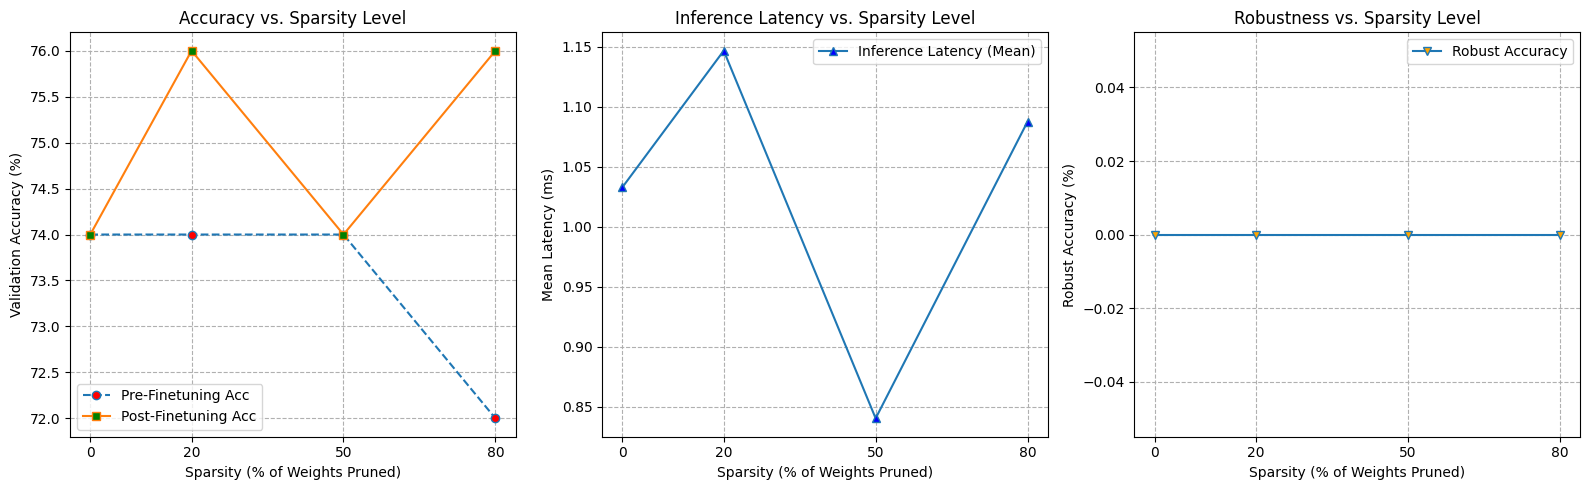

In [6]:
# 1. Accuracy vs. Sparsity Plot
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sparsity_points = df_pruning_final['Sparsity (%)']
acc_pre = df_pruning_final['Acc (Pre)']
acc_post = df_pruning_final['Acc (Post)']

plt.plot(sparsity_points, acc_pre, 'o--', label='Pre-Finetuning Acc', markerfacecolor='red')
plt.plot(sparsity_points, acc_post, 's-', label='Post-Finetuning Acc', markerfacecolor='green')

plt.title('Accuracy vs. Sparsity Level')
plt.xlabel('Sparsity (% of Weights Pruned)')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xticks(sparsity_points)


# 2. Latency vs. Sparsity Plot
plt.subplot(1, 3, 2)
latency = df_pruning_final['Latency (ms) Mean']

plt.plot(sparsity_points, latency, '^-', label='Inference Latency (Mean)', markerfacecolor='blue')

plt.title('Inference Latency vs. Sparsity Level')
plt.xlabel('Sparsity (% of Weights Pruned)')
plt.ylabel('Mean Latency (ms)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xticks(sparsity_points)


# 3. Robustness vs. Sparsity Plot
plt.subplot(1, 3, 3)
robust_acc = df_pruning_final['Robust Acc (PGD Untargeted)']

plt.plot(sparsity_points, robust_acc, 'v-', label='Robust Accuracy', markerfacecolor='orange')

plt.title('Robustness vs. Sparsity Level')
plt.xlabel('Sparsity (% of Weights Pruned)')
plt.ylabel('Robust Accuracy (%)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xticks(sparsity_points)

plt.tight_layout()
plt.show()